Imports

In [81]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import expr
from pyspark.sql.session import SparkSession
from pyspark.sql.types import BooleanType
from pyspark.sql.functions import col, unix_timestamp, to_date, datediff
from helper_functions import translate_to_file_string
import seaborn as sbs

Creating Spark Context

In [82]:
spark = (SparkSession
       .builder
       .appName("HumanResources")
       .getOrCreate())

Setting input file

In [83]:
inputFile = translate_to_file_string("./HRDataset.csv")
# load data file.
# create a DataFrame using an ifered Schema
df = spark.read.option("header", "true") \
    .option("inferSchema", "true") \
    .option("delimiter", ",") \
    .csv(inputFile) \
    .withColumnRenamed("_c0", "Employee_Name")\
    .withColumnRenamed("_c1", "EmpID")\
    .withColumnRenamed("_c2", "MarriedID")\
    .withColumnRenamed("_c3", "MaritalStatusID")\
    .withColumnRenamed("_c4", "GenderID")\
    .withColumnRenamed("_c5", "EmpStatusID")\
    .withColumnRenamed("_c6", "DeptID")\
    .withColumnRenamed("_c7", "PerfScoreID")\
    .withColumnRenamed("_c8", "FromDiversityJobFairID")\
    .withColumnRenamed("_c9", "Salary")\
    .withColumnRenamed("_c10", "Termd")\
    .withColumnRenamed("_c11", "PositionID")\
    .withColumnRenamed("_c12", "Position")\
    .withColumnRenamed("_c13", "State")\
    .withColumnRenamed("_c14", "Zip")\
    .withColumnRenamed("_c15", "DOB")\
    .withColumnRenamed("_c16", "Sex")\
    .withColumnRenamed("_c17", "MaritalDesc")\
    .withColumnRenamed("_c18", "CitizenDesc")\
    .withColumnRenamed("_c19", "HispanicLatino")\
    .withColumnRenamed("_c20", "RaceDesc")\
    .withColumnRenamed("_c21", "DateofHire")\
    .withColumnRenamed("_c22", "DateofTermination")\
    .withColumnRenamed("_c23", "TermReason")\
    .withColumnRenamed("_c24", "EmploymentStatus")\
    .withColumnRenamed("_c25", "Department")\
    .withColumnRenamed("_c26", "ManagerName")\
    .withColumnRenamed("_c27", "ManagerID")\
    .withColumnRenamed("_c28", "RecruitmentSource")\
    .withColumnRenamed("_c29", "PerformanceScore")\
    .withColumnRenamed("_c30", "EngagementSurvey")\
    .withColumnRenamed("_c31", "EmpSatisfaction")\
    .withColumnRenamed("_c32", "SpecialProjectsCount")\
    .withColumnRenamed("_c33", "LastPerformanceReview_Date")\
    .withColumnRenamed("_c34", "DaysLateLast30")\
    .withColumnRenamed("_c35", "Absences")


print(df.printSchema())

root
 |-- Employee_Name: string (nullable = true)
 |-- EmpID: integer (nullable = true)
 |-- MarriedID: integer (nullable = true)
 |-- MaritalStatusID: integer (nullable = true)
 |-- GenderID: integer (nullable = true)
 |-- EmpStatusID: integer (nullable = true)
 |-- DeptID: integer (nullable = true)
 |-- PerfScoreID: integer (nullable = true)
 |-- FromDiversityJobFairID: integer (nullable = true)
 |-- Salary: integer (nullable = true)
 |-- Termd: integer (nullable = true)
 |-- PositionID: integer (nullable = true)
 |-- Position: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zip: integer (nullable = true)
 |-- DOB: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- MaritalDesc: string (nullable = true)
 |-- CitizenDesc: string (nullable = true)
 |-- HispanicLatino: string (nullable = true)
 |-- RaceDesc: string (nullable = true)
 |-- DateofHire: string (nullable = true)
 |-- DateofTermination: string (nullable = true)
 |-- TermReason: string (nullable

Preprocessing

In [84]:
# Fill null values
df.na.fill( {'TermReason': 'Unknown', 'ManagerID': 0, 'DaysLateLast30': 0, 'DateofTermination': '01/01/2021', 'LastPerformanceReview_Date': '01/01/2021'} )

# Converte date-strings to dates
#df = df.withColumn('DateofHire', to_date(unix_timestamp(col('DateofHire'), 'dd/MM/yyyy').cast("timestamp")))
#df = df.withColumn('DOB', to_date(unix_timestamp(col('DOB'), 'dd/MM/yyyy').cast("timestamp")))
#df = df.withColumn('DateofTermination', to_date(unix_timestamp(col('DateofTermination'), 'dd/MM/yyyy').cast("timestamp")))
#df = df.withColumn('LastPerformanceReview_Date', to_date(unix_timestamp(col('LastPerformanceReview_Date'), 'dd/MM/yyyy').cast("timestamp")))

# Add new column for days worked in company
df = df.withColumn("DaysWorked", datediff(col("DateofTermination"), col("DateofHire")))


# Print new Schema
print(df.printSchema())

root
 |-- Employee_Name: string (nullable = true)
 |-- EmpID: integer (nullable = true)
 |-- MarriedID: integer (nullable = true)
 |-- MaritalStatusID: integer (nullable = true)
 |-- GenderID: integer (nullable = true)
 |-- EmpStatusID: integer (nullable = true)
 |-- DeptID: integer (nullable = true)
 |-- PerfScoreID: integer (nullable = true)
 |-- FromDiversityJobFairID: integer (nullable = true)
 |-- Salary: integer (nullable = true)
 |-- Termd: integer (nullable = true)
 |-- PositionID: integer (nullable = true)
 |-- Position: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zip: integer (nullable = true)
 |-- DOB: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- MaritalDesc: string (nullable = true)
 |-- CitizenDesc: string (nullable = true)
 |-- HispanicLatino: string (nullable = true)
 |-- RaceDesc: string (nullable = true)
 |-- DateofHire: string (nullable = true)
 |-- DateofTermination: string (nullable = true)
 |-- TermReason: string (nullable

Show graph

<AxesSubplot:xlabel='RecruitmentSource', ylabel='count'>

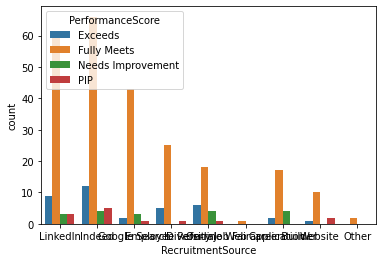

In [85]:
dfPandas = df.toPandas()
sbs.countplot(x=dfPandas['RecruitmentSource'],hue=dfPandas['PerformanceScore'])